In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow_addons.metrics import CohenKappa
import tensorflow.keras.backend as K

import numpy as np
import os
import pandas as pd 
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

2021-12-07 15:45:25.396921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
root="../input/vietai-advance-retinal-disease-detection-2020"

TRAIN_DIR = os.path.join(root, "train/train")
TEST_DIR = os.path.join(root, "test/test")


In [6]:
data = pd.read_csv(os.path.join(root, "train.csv"))
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [7]:
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


In [8]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
data.apply(lambda x: build_label(x), axis=1).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
diabetic retinopathy                                                     212
opacity,macular degeneration                                             212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

In [9]:
LABELS

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')

In [10]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2019)

In [11]:
def preprocessing_image(image):
    """
    Preprocess image after resize and augment data with ImageDataGenerator
    
    Parameters
    ----------
    image: numpy tensor with rank 3
        image to preprocessing
    
    Returns
    -------
    numpy tensor with rank 3
    """
    # TODO: augment more here
    
    return image

In [12]:
penalty = 0.01
regularizer = tf.keras.regularizers.l2(penalty)

In [13]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             featurewise_center=True,
                                                             featurewise_std_normalization=True,
                                                             preprocessing_function=preprocessing_image)

In [ ]:
def build_label_list(row):
    return [LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1]
        
train_data["label"] = train_data.apply(lambda x: build_label_list(x), axis=1)
val_data["label"] = val_data.apply(lambda x: build_label_list(x), axis=1)

In [15]:
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 64
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1
LEARNING_RATE_SCHEDULE_PATIENCE = 5
MAX_EPOCHS = 100 

In [16]:
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data,
                                        directory=TRAIN_DIR, 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=BATCH_SIZE)

Found 2748 validated image filenames belonging to 7 classes.


In [17]:
val_gen = train_datagen.flow_from_dataframe(dataframe=val_data,
                                        directory=TRAIN_DIR, 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        shuffle=False,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=BATCH_SIZE)

Found 687 validated image filenames belonging to 7 classes.


In [23]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
inception_layers = InceptionV3(weights='imagenet', include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))(inputs)
avg_layer = AveragePooling2D(pool_size=(5, 5), strides=(1, 1), padding='valid')(inception_layers)
flat = Flatten()(avg_layer)
outputs = Dense(7, activation='sigmoid')(flat)
        
inception_model = Model(inputs=inputs, outputs=outputs, name="inception_v3_model")

In [24]:
inception_model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), 
              loss='binary_crossentropy', 
              metrics=['accuracy',f1,CohenKappa(num_classes=7)])
inception_model.summary()

Model: "inception_v3_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
average_pooling2d_49 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 14343     
Total params: 21,817,127
Trainable params: 21,782,695
Non-trainable params: 34,432
_________________________________________________________________


In [25]:
steps_per_epoch = train_gen.n // BATCH_SIZE
validation_steps = val_gen.n // BATCH_SIZE

In [26]:
mcp = keras.callbacks.ModelCheckpoint("inception_model.h5", monitor="val_f1", save_best_only=True, save_weights_only=True, verbose=1,mode='max')
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=LEARNING_RATE_SCHEDULE_FACTOR, mode='max', patience=LEARNING_RATE_SCHEDULE_PATIENCE, min_lr=1e-8, verbose=1)
callbacks = [mcp, rlr]

In [27]:
inception_history = inception_model.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs= MAX_EPOCHS,
                                  verbose=1,
                                  validation_data=val_gen,
                                  validation_steps=validation_steps,
                                  callbacks=callbacks
                             )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2021-12-07 15:53:30.614166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116]

Epoch 1/100


2021-12-07 15:53:37.233724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-07 15:53:38.030480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-07 15:53:38.096831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


42/42 [==============================] - 51s 903ms/step - loss: 0.4130 - accuracy: 0.4018 - f1: 0.4769 - val_loss: 3.4330 - val_accuracy: 0.1531 - val_f1: 0.1256

Epoch 00001: val_f1 improved from -inf to 0.12559, saving model to inception_model.h5
Epoch 2/100
42/42 [==============================] - 21s 489ms/step - loss: 0.2467 - accuracy: 0.6435 - f1: 0.7318 - val_loss: 10.1407 - val_accuracy: 0.1562 - val_f1: 0.1283

Epoch 00002: val_f1 improved from 0.12559 to 0.12829, saving model to inception_model.h5
Epoch 3/100
42/42 [==============================] - 20s 473ms/step - loss: 0.1871 - accuracy: 0.7211 - f1: 0.7937 - val_loss: 0.5385 - val_accuracy: 0.3766 - val_f1: 0.5074

Epoch 00003: val_f1 improved from 0.12829 to 0.50741, saving model to inception_model.h5
Epoch 4/100
42/42 [==============================] - 20s 483ms/step - loss: 0.1617 - accuracy: 0.7485 - f1: 0.8419 - val_loss: 0.4491 - val_accuracy: 0.5031 - val_f1: 0.6180

Epoch 00004: val_f1 improved from 0.50741 to 0.

In [33]:
inception_model.save(os.path.join("./","final_inception_v3_model.h5"))

In [34]:
inception_model.evaluate(val_gen,batch_size=20)

11/11 [==============================] - 4s 383ms/step - loss: 0.3373 - accuracy: 0.6900 - f1: 0.8245


[0.3373069167137146, 0.6899563074111938, 0.8245014548301697]

In [35]:
inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
efficient_layers = tf.keras.applications.EfficientNetB0(weights='imagenet', 
                                              include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))(inputs)
avg_layer = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(efficient_layers)
flat = Flatten()(avg_layer)
outputs = Dense(7, activation='sigmoid')(flat)

efficient_model = Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_model")

16711680/16705208 [==============================] - 0s 0us/step


In [36]:
efficient_model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), 
              loss='binary_crossentropy', 
              metrics=['accuracy',f1,CohenKappa(num_classes=7)])
efficient_model.summary()

Model: "EfficientNetB0_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
average_pooling2d_50 (Averag (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 80647     
Total params: 4,130,218
Trainable params: 4,088,195
Non-trainable params: 42,023
_________________________________________________________________


In [37]:
eff_mcp = keras.callbacks.ModelCheckpoint("efficient_model.h5", monitor="val_f1", save_best_only=True, save_weights_only=True, verbose=1,mode='max')
eff_rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=LEARNING_RATE_SCHEDULE_FACTOR, mode='max', patience=LEARNING_RATE_SCHEDULE_PATIENCE, min_lr=1e-8, verbose=1)
efficient_callbacks = [eff_mcp, eff_rlr]

In [38]:
efficient_history = efficient_model.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs= MAX_EPOCHS,
                                  verbose=1,
                                  validation_data=val_gen,
                                  validation_steps=validation_steps,
                                  callbacks=efficient_callbacks
                             )

Epoch 1/100
42/42 [==============================] - 33s 590ms/step - loss: 0.4384 - accuracy: 0.3752 - f1: 0.4334 - val_loss: 0.7756 - val_accuracy: 0.2125 - val_f1: 0.2124

Epoch 00001: val_f1 improved from -inf to 0.21244, saving model to efficient_model.h5
Epoch 2/100
42/42 [==============================] - 23s 534ms/step - loss: 0.2748 - accuracy: 0.6000 - f1: 0.7095 - val_loss: 0.6766 - val_accuracy: 0.2141 - val_f1: 0.3799

Epoch 00002: val_f1 improved from 0.21244 to 0.37993, saving model to efficient_model.h5
Epoch 3/100
42/42 [==============================] - 23s 533ms/step - loss: 0.1848 - accuracy: 0.7211 - f1: 0.8039 - val_loss: 0.8516 - val_accuracy: 0.0578 - val_f1: 0.2694

Epoch 00003: val_f1 did not improve from 0.37993
Epoch 4/100
42/42 [==============================] - 22s 527ms/step - loss: 0.1332 - accuracy: 0.7730 - f1: 0.8693 - val_loss: 0.7901 - val_accuracy: 0.2125 - val_f1: 0.3423

Epoch 00004: val_f1 did not improve from 0.37993
Epoch 5/100
42/42 [========

In [39]:
efficient_model.save(os.path.join("./","final_efficientB0_model.h5"))

In [40]:
efficient_model.evaluate(val_gen,batch_size=20)

11/11 [==============================] - 4s 321ms/step - loss: 0.3723 - accuracy: 0.6958 - f1: 0.8249


[0.372284471988678, 0.6957787275314331, 0.8249229788780212]

In [44]:
inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
resnet_layers = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                              include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))(inputs)
avg_layer = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(resnet_layers)
flat = Flatten()(avg_layer)
outputs = Dense(7, activation='sigmoid')(flat)

resnet_model = Model(inputs=inputs, outputs=outputs, name="Resnet50_model")

In [42]:
res_mcp = keras.callbacks.ModelCheckpoint("reset_model.h5", monitor="val_f1", save_best_only=True, save_weights_only=True, verbose=1,mode='max')
res_rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=LEARNING_RATE_SCHEDULE_FACTOR, mode='max', patience=LEARNING_RATE_SCHEDULE_PATIENCE, min_lr=1e-8, verbose=1)
resnet_callbacks = [res_mcp, res_rlr]

In [45]:
resnet_model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), 
              loss='binary_crossentropy', 
              metrics=['accuracy',f1,CohenKappa(num_classes=7)])
resnet_model.summary()

Model: "Resnet50_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_52 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [46]:
resnet_history = resnet_model.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs= MAX_EPOCHS,
                                  verbose=1,
                                  validation_data=val_gen,
                                  validation_steps=validation_steps,
                                  callbacks=resnet_callbacks
                             )

Epoch 1/100
42/42 [==============================] - 28s 548ms/step - loss: 0.4311 - accuracy: 0.3997 - f1: 0.4718 - val_loss: 352.1854 - val_accuracy: 0.1531 - val_f1: 0.1256

Epoch 00001: val_f1 improved from -inf to 0.12559, saving model to reset_model.h5
Epoch 2/100
42/42 [==============================] - 22s 508ms/step - loss: 0.2832 - accuracy: 0.5777 - f1: 0.6711 - val_loss: 230.1763 - val_accuracy: 0.1531 - val_f1: 0.1256

Epoch 00002: val_f1 did not improve from 0.12559
Epoch 3/100
42/42 [==============================] - 21s 501ms/step - loss: 0.2313 - accuracy: 0.6424 - f1: 0.7398 - val_loss: 0.6599 - val_accuracy: 0.2141 - val_f1: 0.3614

Epoch 00003: val_f1 improved from 0.12559 to 0.36144, saving model to reset_model.h5
Epoch 4/100
42/42 [==============================] - 21s 500ms/step - loss: 0.1804 - accuracy: 0.7116 - f1: 0.8139 - val_loss: 0.6642 - val_accuracy: 0.2141 - val_f1: 0.3614

Epoch 00004: val_f1 did not improve from 0.36144
Epoch 5/100
42/42 [============

In [47]:
resnet_model.save(os.path.join("./","final_resnet50_model.h5"))

In [48]:
resnet_model.evaluate(val_gen,batch_size=20)

11/11 [==============================] - 4s 341ms/step - loss: 0.4392 - accuracy: 0.6565 - f1: 0.7822


[0.43918582797050476, 0.6564774513244629, 0.7822424173355103]

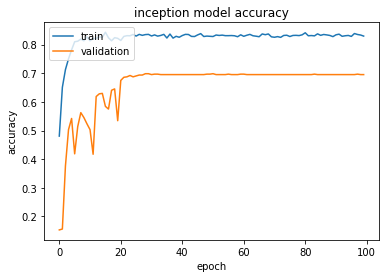

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('inception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('inception_model_accuracy.png')

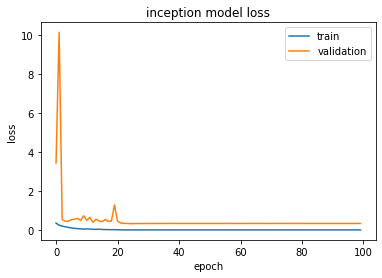

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('inception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig('inception_model_loss.png')

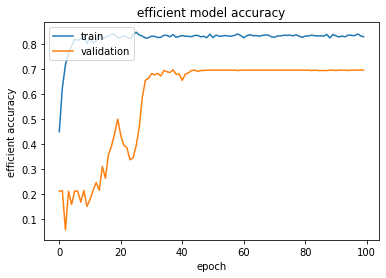

<Figure size 432x288 with 0 Axes>

In [51]:
plt.plot(efficient_history.history['accuracy'])
plt.plot(efficient_history.history['val_accuracy'])
plt.title('efficient model accuracy')
plt.ylabel('efficient accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('efficient_model_accuracy.png')

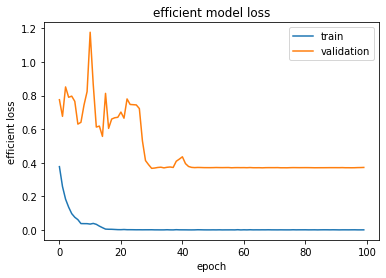

<Figure size 432x288 with 0 Axes>

In [52]:
plt.plot(efficient_history.history['loss'])
plt.plot(efficient_history.history['val_loss'])
plt.title('efficient model loss')
plt.ylabel('efficient loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig('efficient_model_loss.png')

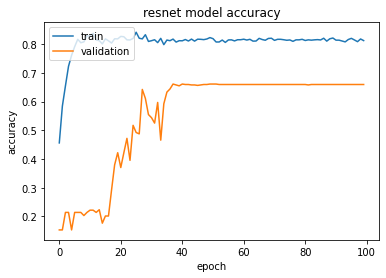

<Figure size 432x288 with 0 Axes>

In [53]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('resnet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('resnet_model_accuracy.png')

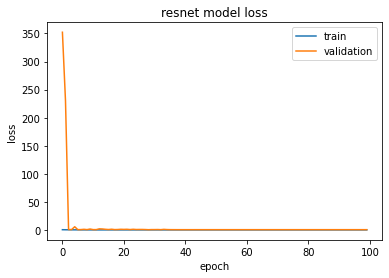

<Figure size 432x288 with 0 Axes>

In [54]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('resnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig('resnet_model_loss.png')

In [58]:
ensemble_models = [inception_model ,efficient_model, resnet_model]
ensemble_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
ensemble_outputs = [ensemble_model(ensemble_input) for ensemble_model in ensemble_models]
ensemble_output = tf.keras.layers.Average()(ensemble_outputs)
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output)

In [61]:
ensemble_model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), 
              loss='binary_crossentropy', 
              metrics=['accuracy',f1,CohenKappa(num_classes=7)])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3_model (Functional) (None, 7)            21817127    input_17[0][0]                   
__________________________________________________________________________________________________
EfficientNetB0_model (Functiona (None, 7)            4130218     input_17[0][0]                   
__________________________________________________________________________________________________
Resnet50_model (Functional)     (None, 7)            23602055    input_17[0][0]                   
______________________________________________________________________________________________

In [78]:
ensemble_model.save(os.path.join("./","ensemble_model.h5"))

In [63]:
ensemble_model.evaluate(val_gen,batch_size=20)

11/11 [==============================] - 10s 364ms/step - loss: 0.2288 - accuracy: 0.7260 - f1: 0.8313 - cohen_kappa: 0.6667


[0.2391616851091385,
 0.6972343325614929,
 0.8297601342201233,
 0.6319683790206909]

In [64]:
from sklearn.metrics import multilabel_confusion_matrix

pred = ensemble_model.predict(val_gen)
pred_bool = (pred>0.5)
y_pred =  pred_bool.astype(int)


truth = val_gen.classes
print(truth)
true= np.zeros(np.shape(pred), dtype=int)
for i in range(len(true)):
    for j in truth[i]:
        true[i][j] = 1
print(true)


cm=multilabel_confusion_matrix(true, y_pred)

[[0, 3], [5], [5, 1], [4], [3], [1], [1], [5, 0, 3], [4], [4], [0, 3], [2], [5], [5], [5, 0, 3], [5, 2], [1, 6], [6], [2], [4], [5], [5], [4], [0, 3], [1], [0], [5], [6], [0], [5, 2], [0], [0], [0], [4], [5, 6], [5, 2], [4], [4], [1], [2], [5], [5, 0], [2], [2], [2], [2], [5, 0, 3, 2], [4], [4], [5], [5], [5, 0, 3], [5, 1], [2], [4], [6], [0], [5], [4], [6], [4], [1], [5, 6], [0, 3], [1], [4], [3], [4], [4], [0, 6], [0], [2], [0, 3], [5, 2], [5], [0, 3], [5], [5, 2], [5], [5], [5, 2], [1], [4], [4], [4], [5, 0], [5], [0, 3], [5], [1], [0, 3], [5], [4], [5], [5, 0, 3], [4], [0], [5, 2], [5, 3, 6], [6], [5, 2], [0, 3], [5, 0, 3], [2], [5], [4], [4], [0], [4], [5], [5, 2], [5, 0, 3], [5], [5, 6], [5, 1, 6], [2], [5, 1], [5, 1], [0], [6], [0], [5], [5, 1], [5], [5, 1], [5, 2], [2], [5, 1], [4], [5, 0], [1], [4], [5, 1, 2], [4], [6], [1], [5, 3, 6], [5], [1, 3, 6], [5, 0], [5, 1, 6], [5], [0, 3], [5, 0, 3], [4], [5, 2], [1], [5, 0], [5], [4], [5], [1], [5, 0, 6], [5], [5, 0, 3], [2], [5], [

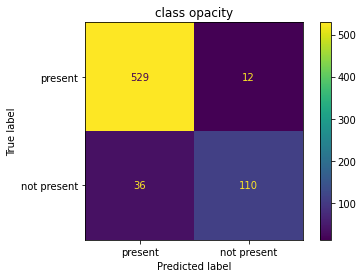

<Figure size 432x288 with 0 Axes>

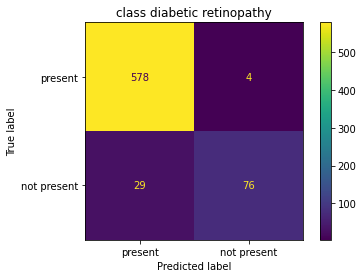

<Figure size 432x288 with 0 Axes>

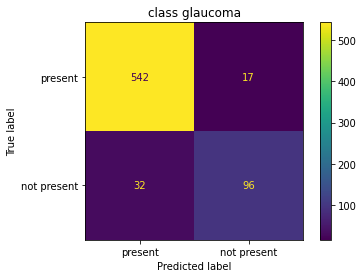

<Figure size 432x288 with 0 Axes>

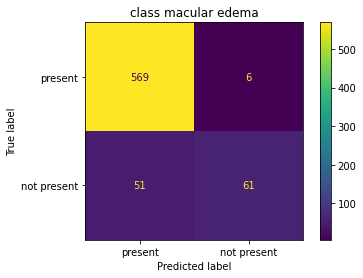

<Figure size 432x288 with 0 Axes>

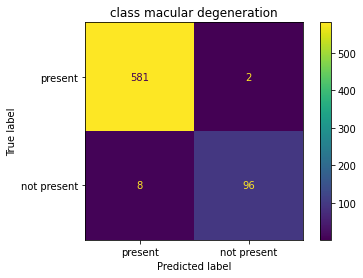

<Figure size 432x288 with 0 Axes>

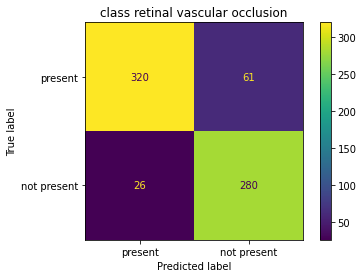

<Figure size 432x288 with 0 Axes>

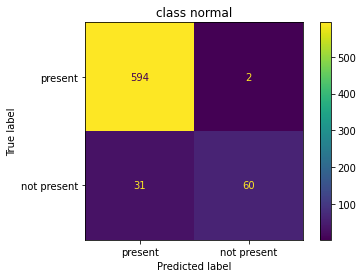

<Figure size 432x288 with 0 Axes>

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
matrix = cm

disease = np.array(["opacity",	"diabetic retinopathy",	"glaucoma",	
                    "macular edema",	"macular degeneration",	
                    "retinal vascular occlusion",	"normal"])

for i in range(7):
    disp = ConfusionMatrixDisplay(matrix[i], display_labels=['present', 'not present'])
    disp.plot(values_format='d')
    disp.ax_.set_title(f'class {disease[i]}')
    plt.show()
    plt.savefig('confusion_matrix_{}.png'.format(disease[i]))

In [67]:
test_df = pd.read_csv(os.path.join(root,"sample_submission.csv"))
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0


In [68]:
test_gen = train_datagen.flow_from_dataframe(dataframe=test_df,
                                             directory=TEST_DIR,
                                             x_col="filename",
                                             class_mode=None,
                                             shuffle=False,
                                             target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                             batch_size=BATCH_SIZE)

Found 350 validated image filenames.


In [ ]:
ensemble_model.load_weights("ensemble_model.h5")

In [70]:
predictions = ensemble_model.predict_generator(test_gen)

In [72]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels
LABELS = list(LABELS)

def probs2label(probs):
    ''' Return real index following LABELS
    '''
    global LABELS, labels
    result = " ".join([str(LABELS.index(labels[idx])) for idx, prob in enumerate(probs) if prob > 0.5])
    print(result)
    return result

In [73]:
for idx, row in test_df.iterrows():
    test_df.loc[idx]['predicted'] = probs2label(predictions[idx])

6
4 0
0
0
2 0
2 4 0
6
1 3
5
2
1 0
1 0
2 0
2 3 5
3 5
0
4
0
1 3
0
1 3 0
0
0
6
6
6
1 3 0
4
0
1 0
1 3
6
3 5
4
0

4 0
6
4 0
4 0
0 5
1 3
5
1 3
1 3 0
3 0 5


6
0
5
1 3 0
4
6
0

6
1 0
0
4
5
4
1 0
1
3 5
5
1 0
6
4 0
3 0
1 0
6
1 0
4
4
4
0
1 3
3 0 5
1 3 0
1 3 0
0
4
6
4 0
4 3 0
0 5
0
5
2
2 3 0 5
0
0
0
1 0
6
6
4 0
1 3 0
1
3 0 5
0
6
1 3
3

6
2 0
2 5
0
6
2 0
2
6
1 3 0
6
0
4 0
0
6
6
0 5
6
1 0
4 0 5

1 3 0
1 3
4
4
5
6
1 3 0
3 5
1 0
1 3 0
1 3 0
5
1 0 5
1 0
1 0
0
1 3 0
2
1 0
3 0 5
2 3 0 5
4
1 0
2 0
6
1 3
2 0
2
4
1
2
2
3 0 5
1

6
2 0
4 0
1 3 0
6
1
0
0
0
0
6
5
0
1 3 0
1 3 0
1 0
2 0
2
0
1 3
0
1 3
1 3
1 3 0
1 3
6
1 0
0
2
1 3 0
4
0
0
4
2 0
5
0
1 3 0
6
1 3
4
2
2
2 4 0
4
0
3 0

4
1
1 3
3 5
5
1 3 0

1 3 0
1 3
6
4 0
2 0
2
1 0
1 3
1 3 0
5
3 0 5
1 3 0
1 5
6
1 3
4
0
1 3 0
6
3 0 5
1 3
0
6
2
6
4
4
5
2
0 5
2 0
6
4
2
6
4 0
1 3 0
4 0
2 0
0
2 0 5
0
2
4
2

2
0
3 0 5
4 0
2
6
4 0
2 5
3 5


1 0
2
3 5
4 0
2
6
2
4 0
0 5
0
3 0 5
2
1 3 0
1 3
6
1 0
2 5
4
1
0
1 3
4
0 5
1 3 5
1 0
2
4 0
2 3 0 5
2 0

0
0
2
2 4
4
0
3 5
0


3 0 5
1 0
6
1

In [74]:
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,6
1,b193b6a6d68d.jpg,4 0
2,07e4191fa3a8.jpg,0
3,b1a911cb2e6c.jpg,0
4,d8ab9cda1b33.jpg,2 0


In [75]:
test_df.to_csv("submission.csv", index=False)